In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:

class Graph:

    def __init__(self, pair_df):
        
        # read file at addres filename
        
        # the set of followers and followee
        self.follower_set = set(pair_df["follower"])
        self.followee_set = set(pair_df["followee"])
        
        # the set of people who are not followed by anyone
        self.not_followed_set = self.follower_set - self.followee_set
     
        # the set of vertex in the graph, and its count
        self.vertices = self.follower_set | self.followee_set
        self.num_vertices = len(self.vertices)   

        # create a 2-col df [user, number of people this user follows]
        self.follow_count = pair_df.groupby("follower").count().reset_index().rename(columns={"followee": "count"})
        
        # finally, get a 3-col df [follower, followee, count]
        # where count is the total number of people that the follower follows  
        self.followers = pair_df.merge(self.follow_count, on="follower")
             
        self.follow_count = pair_df.groupby("followee").count()
        self.follow_count.columns=["count"]
        self.follow_count.sort_values(by=["count"], ascending=False, inplace=True)
        self.follow_count.reset_index(inplace=True)
    
    def get_follow_counts(self):
        return self.follow_count
    
    # compute the page ranks after n_iter iterations, using a sql-like join based implementation
    # dumping_factor is the probability to pick a new random page in the graph.
    def compute_page_ranks( self, dumping_factor = 0.15, n_iter = 100 ):

        # a constant 1 / nVertices
        uniform_weight = 1.0/self.num_vertices

        # the initial ranks (we will reassign this rdd during the computation)
        ranks = pd.DataFrame({"follower": list(self.vertices), "rank": uniform_weight})

        # the random surf term (because sometimes we just go to any random page)
        random_surf_term = dumping_factor * uniform_weight

        # the weight that a dangling user adds to the other users
        # the word 'dangling' refers to users who are followee but not follower
        # after such a user, we assume that the surfer choose the next page randomly
        dangling_user_factor = (1-dumping_factor) * uniform_weight

        # main loop: n_iter iterations
        for i in range(n_iter):
            
            # get a df [follower, rank, followee, count]
            # and reduce it to get the ranks from the edges of the graph only
            joined_ranks = ranks.merge(self.followers, how="left", on="follower")        

            # compute the sum of rank of dangling users
            dangling_user_rank_sum = joined_ranks[pd.isna(joined_ranks["count"])]["rank"].sum()
            
            # now, we have everything to update the ranks 
            # every entry (follower, followee) adds a weight (rank / count) to the new rank of followee,
            # where rank is the rank of followers and count the total number of people that follower follows
            joined_ranks.dropna(inplace=True)                          
            joined_ranks["rank"] = np.divide(joined_ranks["rank"], joined_ranks["count"])
            ranks = joined_ranks.groupby("followee")["rank"].sum().reset_index()
            ranks.columns = ["follower", "rank"]

            # add random surfer factor and dangling user factors
            dangling_user_term = dangling_user_rank_sum * dangling_user_factor
            default_term = dangling_user_term + random_surf_term
            ranks["rank"] = ranks["rank"].map(lambda rank: default_term + (1-dumping_factor) * rank)
            
           # then add the ranks for peoples who are not followed by anyone
            not_followed_df = pd.DataFrame({"follower": list(self.not_followed_set), "rank": default_term})
            
            # concatenate the result with the fixed ranks (rank of people who are not followed)
            ranks = pd.concat([ranks, not_followed_df])

        # finally, after n_iter iterations, sort the result by rank and break ties lexicographically.
        return ranks\
            .sort_values(by=["rank", "follower"], ascending=[0, 1])\
            .rename(columns={"follower":"name"})\
            .reset_index().drop("index", axis=1)

In [91]:
pair_df = pd.read_csv("../follower_followee.txt", names=["follower", "followee"])

graph = Graph(pair_df)


counts = graph.get_follow_counts()
print(counts.head(10))

print("\n=======================================\n")

ranks = graph.compute_page_ranks()
print(ranks.head(10))




                  followee  count
0    Johann Sebastian Bach    229
1     Ludwig van Beethoven    209
2          Igor Stravinsky    174
3  Wolfgang Amadeus Mozart    169
4           Richard Wagner    165
5        Arnold Schoenberg    153
6              Franz Liszt    151
7            Aaron Copland    144
8          Robert Schumann    143
9         Olivier Messiaen    138


                      name      rank
0    Johann Sebastian Bach  0.015070
1     Ludwig van Beethoven  0.012547
2  Wolfgang Amadeus Mozart  0.010260
3           Richard Wagner  0.008902
4              Franz Liszt  0.008619
5          Robert Schumann  0.008052
6          Igor Stravinsky  0.007619
7             Joseph Haydn  0.007093
8          Frédéric Chopin  0.006640
9  Nikolai Rimsky-Korsakov  0.006571


In [85]:

composers_info = pd.read_csv("../composer_information.txt", sep='\t', names=["name", "dob", "birthplace", "genre"])
print(composers_info.head())

                  name    dob        birthplace     genre
0               Peirol  1160s          Auvergne  medieval
1     Paolo da Firenze   1355          Florence  medieval
2       Nicolas Grenon   1375           Cambrai  medieval
3   Raimbaut of Orange   1147  Orange, Vaucluse  medieval
4  Folquet de Marselha  1150s         Marseille  medieval


In [86]:
# given the row 'dob' (date of birth), compute the decade
def get_decade(dob):
    if len(dob) < 4 or not dob[:4].isdigit():
        return 
    return int(dob[:3] + "0")

# adds the 'decade' column to the dataframe
composers_info["decade"] = composers_info["dob"].map(get_decade)

print(composers_info.head())

                  name    dob        birthplace     genre  decade
0               Peirol  1160s          Auvergne  medieval  1160.0
1     Paolo da Firenze   1355          Florence  medieval  1350.0
2       Nicolas Grenon   1375           Cambrai  medieval  1370.0
3   Raimbaut of Orange   1147  Orange, Vaucluse  medieval  1140.0
4  Folquet de Marselha  1150s         Marseille  medieval  1150.0


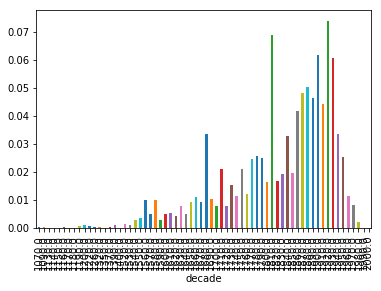

In [120]:
ranks_with_info = ranks.merge(composers_info, on="name").dropna()

rank_sum_per_decade = ranks_with_info.groupby("decade")["rank"].aggregate("sum").sort_index()

rank_sum_per_decade.plot(kind="bar")


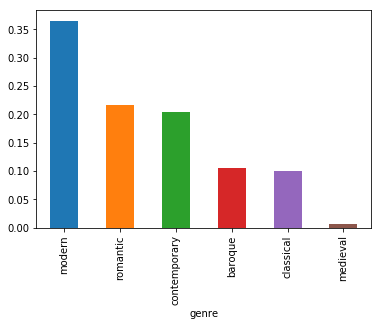

In [90]:
# for each musical genre in wikipedias categories, compute the sums of the ranks of composers of this genre.
rank_sum_per_genre = ranks_with_info.groupby("genre")["rank"].aggregate("sum").sort_values(ascending=False)

# plot the result to a bar chart
rank_sum_per_genre.plot(kind="bar")

In [121]:
# heap-based implementation to find the n largest items
from heapq import nlargest

# use the results of the page rank to compute the n most important links in wikipedia composers page
def most_important_links(n=10):

    ranks_dict = ranks.set_index("name").to_dict()["rank"]
    weight_set = set()
    
    def concat_names(name1, name2):
        n1, n2 = sorted((name1, name2))
        return n1 + " <-> " + n2
    
    def weight(name1, name2):
        return ranks_dict[name1] * ranks_dict[name2]
    
    for _, row in pair_df.iterrows():
        n1, n2 = ( row["follower"], row["followee"] )
        tmp = ( concat_names(n1, n2), weight(n1, n2) )
        weight_set.add(tmp)
        
    bests = nlargest(n, weight_set, key=lambda pair: pair[1])
    
    return [names for names, _ in bests]

    
for link in most_important_links():
    print(link)

Johann Sebastian Bach <-> Ludwig van Beethoven
Johann Sebastian Bach <-> Wolfgang Amadeus Mozart
Johann Sebastian Bach <-> Richard Wagner
Franz Liszt <-> Johann Sebastian Bach
Ludwig van Beethoven <-> Wolfgang Amadeus Mozart
Johann Sebastian Bach <-> Robert Schumann
Ludwig van Beethoven <-> Richard Wagner
Franz Liszt <-> Ludwig van Beethoven
Johann Sebastian Bach <-> Joseph Haydn
Ludwig van Beethoven <-> Robert Schumann
